#**Título:** Entrenar dos modelos usando Clustering
#**Alumno:** JASSON JAIR MORA PUIN
#**Profesor:** JUAN CARLOS VALENCIA
#**Curso:** NRC-5835-Machine Learning
#**Fecha:** 07/06/2025

In [1]:
# Primero instalamos las  Librerías para manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, adjusted_rand_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import calinski_harabasz_score


#  Pasos generales:
1. Seleccionar dos Dataset de interés para el análisis de datos.
2. Tratamiento exploratorio de Dataset house_votes
3. Identificar variable objetivo y continuas a analizar del Dataset house_votes
4. Aplicar método Silhouette score para determinar el número de clústers óptimo del Dataset house_votes
5. Aplicar K-means al Dataset house_votes con el número óptimo de clústers
6. Evaluar los resultados del entrenamiento de house_votes
7. Tratamiento exploratorio de Dataset adult
8. Identificar variables objetivo y continuas a analizar del Dataset adult
9. Aplicar método calinski_harabasz_score para determinar el número de clústers óptimo del Dataset adult
10. Aplicar K-means al Dataset adult con el número óptimo de clústers
11.Evaluar los resultados del entrenamiento de house_votes


#  1. Seleccionar dos Dataset de interés para el análisis de datos.

Dado que en la entrega anterior se trabajó con los Datasets house_votes y adult y sabiendo qué el algoritmo de clustering (K-means) trabaja unicamente con variables numéricas continuas, se decide reutilizar el tratamiento realizado anteriormente

#  2. Tratamiento exploratorio de Dataset house_votes

El EDA sobre el Dataset realizado por [Mora J. (2025)] (https://colab.research.google.com/drive/1JafYItjZ-3VuJyHSlKANtHpdHKZ8MGUe?usp=sharing) contiene la explicación detallada de los procesos realizados sobre el Dataset

In [2]:
# Definimos la url del dato
url_house_votes_ds = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

# Columnas del Dataset de house votes
house_votes_columns = [
    'Class Name:',
    'handicapped-infants',
    'water-project-cost-sharing',
    'adoption-of-the-budget-resolution',
    'education_num',
    'marital',
    'physician-fee-freeze',
    'el-salvador-aid',
    'religious-groups-in-schools',
    'anti-satellite-test-ban',
    'aid-to-nicaraguan-contras',
    'mx-missile',
    'immigration',
    'synfuels-corporation-cutback',
    'education-spending',
    'superfund-right-to-sue',
    'crime',
    'duty-free-exports',
    'export-administration-act-south-africa'
]

# Cargamos al dataframe df_house los datos del Dataset correspondiente
df_house_votes = pd.read_csv(url_house_votes_ds, delimiter=',', header=None, names=house_votes_columns)

df_house_votes.head()


,Class Name:,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,education_num,marital,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,NaN,NaN
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,NaN,NaN
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,NaN,NaN
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,NaN,NaN
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,NaN,NaN


In [3]:
# Eliminamos las columnas que no son necesarias, dado que todos sus valores son NaN, no hacen parte del análisis
df_house_votes = df_house_votes.drop(['duty-free-exports', 'export-administration-act-south-africa'], axis=1)
# Dado que con excepción de la columna 'Class Name', todas las columnas son categóricas, se deben convertir a tipo numerico
# Cómo en todas las columnas se tienen 3 valores, se toma la decisión de reemplazar los valores de las columnas con '?' por la moda de la variable, 'y' -> 1, 'n' -> 0
# Se considera que los valores de las columnas son binarios "Binary Variables" (Bishop, 2006, p. 68).

# Primero convertimos 'y' y 'n' a valores numéricos
df_house_votes = df_house_votes.replace({
    'y': 1,
    'n': 0
})

# Luego reemplazamos los '?' por la moda de cada columna
for column in df_house_votes.columns:
    if column != 'Class Name:':  # Excluimos la columna de clase
        mode_value = df_house_votes[column].mode()[0]
        df_house_votes[column] = df_house_votes[column].replace('?', mode_value)

# Verificar los cambios
df_house_votes.describe()
# Validar datos
df_house_votes.head()

/tmp/ipykernel_897/4093678440.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_house_votes[column] = df_house_votes[column].replace('?', mode_value)


,Class Name:,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,education_num,marital,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime
0,republican,0,1,0,1,1,1,0,0,0,1,0,1,1,1,0,1
1,republican,0,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1
2,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,1,0,0
3,democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
4,democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,1,1,1


#  3. Identificar variable objetivo y continuas a analizar del Dataset house_votes

La variable objetivo del Dataset house_votes es "Class Name:", el resto de variables son continuas debido a la transformación de variables binarias. Se realiza entonces el tratamiento sobre el Dataset y el escalado de datos correspondiente

In [4]:
# Eliminar columnas que no aportan al clustering
X = df_house_votes.drop(['Class Name:'], axis=1)

# Escalado de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 4. Aplicar método Silhouette score para determinar el número de clústers óptimo del Dataset house_votes


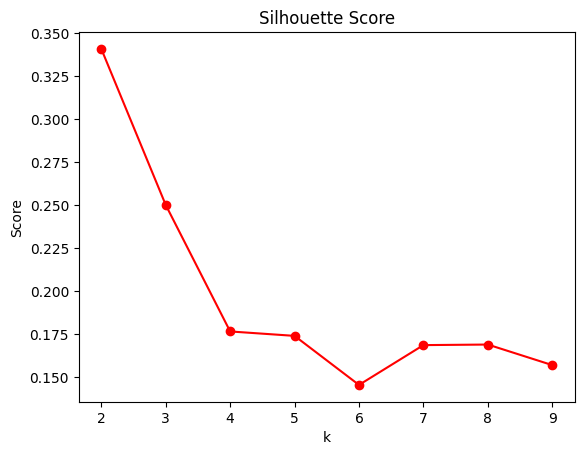

In [5]:
### Elegir número óptimo de clusters (Método de Silhouette score)

inertias = []
silhouettes = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, kmeans.labels_))

# Silhouette
plt.plot(K, silhouettes, 'ro-')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()

# 5. Aplicar K-means al Dataset house_votes con el número óptimo de clústeres

Del paso anterior, de acuerdo al método Silhouette score se cálcula el número K = 2, cómo se tienen muchas variables binarias, se reduce a dos dimensiones para graficas, usando PCA.

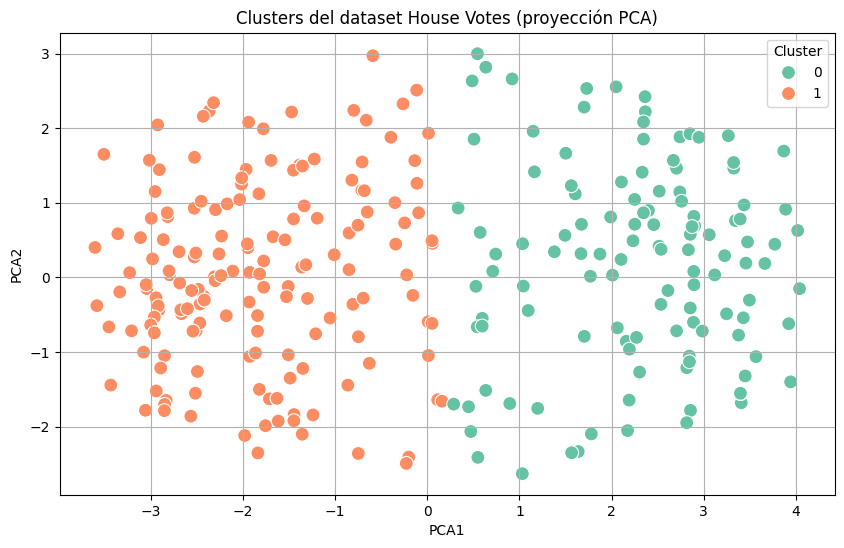

In [6]:
# Aplicar K-means al Dataset house_votes con el número óptimo de clústers
kmeans = KMeans(n_clusters=2, random_state=42)
df_house_votes['Cluster'] = kmeans.fit_predict(X_scaled)

### Visualizar clústeres
# Reducimos a 2 dimensiones para visualización
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)
df_house_votes['PCA1'] = components[:, 0]
df_house_votes['PCA2'] = components[:, 1]

# Graficamos los clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_house_votes, palette='Set2', s=100)
plt.title('Clusters del dataset House Votes (proyección PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 6. Evaluar los resultados del entrenamiento de house_votes

In [7]:

# Codificar las etiquetas reales
le = LabelEncoder()
true_labels = le.fit_transform(df_house_votes['Class Name:'])  # 'democrat' → 0, 'republican' → 1

# Comparar con los datos
print("Confusion Matrix:\n", confusion_matrix(true_labels, df_house_votes['Cluster']))

# Índice de Rand Ajustado
ari = adjusted_rand_score(true_labels, df_house_votes['Cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, df_house_votes['Cluster']))

Confusion Matrix:
 [[ 41 226]
 [155  13]]
Adjusted Rand Index (ARI): 0.5639

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.15      0.18       267
           1       0.05      0.08      0.06       168

    accuracy                           0.12       435
   macro avg       0.13      0.12      0.12       435
weighted avg       0.15      0.12      0.13       435



# 7. Tratamiento exploratorio de Dataset adult

El EDA sobre el Dataset realizado por [Mora J. (2025)] (https://colab.research.google.com/drive/1JafYItjZ-3VuJyHSlKANtHpdHKZ8MGUe?usp=sharing) contiene la explicación detallada de los procesos realizados sobre el Dataset


In [8]:
# Definimos las urls de los datos
url_adult_ds = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# Columnas del Dataset de adult, según documento de referencia
adult_columns = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_week',
    'native_country',
    'label'
]

# Cargamos al dataframe df_adult los datos del Dataset correspondiente
df_adult = pd.read_csv(url_adult_ds, delimiter=',', header=None, names=adult_columns)

df_adult = pd.read_csv(url_adult_ds, delimiter=',', header=None, names=adult_columns)
df_adult.head()

,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# Validar si hay duplicados en las filas
hay_duplicados = df_adult.duplicated().any()
print("¿Hay filas duplicadas?", hay_duplicados)
# Se evidencian duplicados, se toma la decisión de eliminarlos
df_adult = df_adult.drop_duplicates()

# Se eliminan los valores de las variables que no son relevantes para el análisis, si es que existen
df_adult = df_adult[(df_adult['age'] > 0) & (df_adult['fnlwgt'] > 0) ]
df_adult.head()

¿Hay filas duplicadas? True


,age,workclass,fnlwgt,education,education_num,marital,occupation,relationship,race,sex,capital_gain,capital_loss,hours_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 8. Identificar variables objetivo y continuas a analizar del Dataset adult

La variable objetivo del Dataset house_votes es "label", las variables continuas son 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_week'. Se realiza entonces el tratamiento sobre el Dataset y el escalado de datos correspondiente

In [10]:
# Lista de columnas continuas
adult_continuous_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_week']

# Conservar solo las columnas continuas
X = df_adult[adult_continuous_columns].copy()

# Escalado de datos

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 9. Aplicar método calinski harabasz para determinar el número de clústers óptimo del Dataset adult

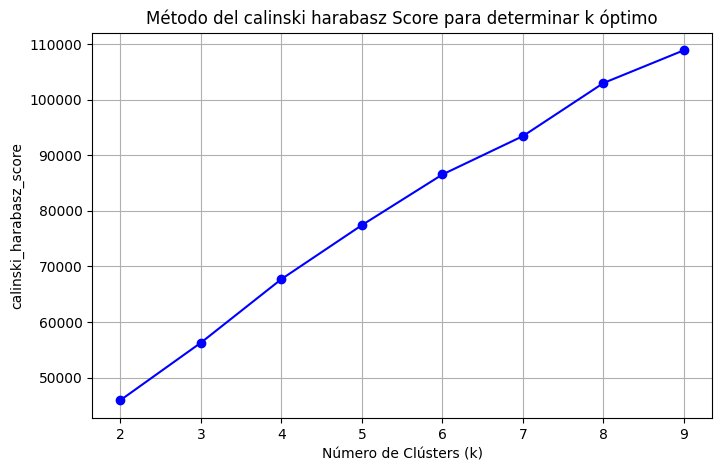

In [11]:
# Evaluar K entre 2 y 10
nb_clusters = [2, 3, 5, 6, 7, 8, 9, 10]
ch_scores = []
for n in nb_clusters:
    km = KMeans(n_clusters=n)
    Y = km.fit_predict(X)
    ch_scores.append(calinski_harabasz_score(X, Y))
# 4. Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(K, ch_scores, 'bo-')
plt.xlabel('Número de Clústers (k)')
plt.ylabel('calinski_harabasz_score')
plt.title('Método del calinski harabasz Score para determinar k óptimo')
plt.grid(True)
plt.show()

# 10. Aplicar K-means al Dataset adult con el número óptimo de clústers

Según Bonaccorso, G. (2018), se debe elegir el k=9


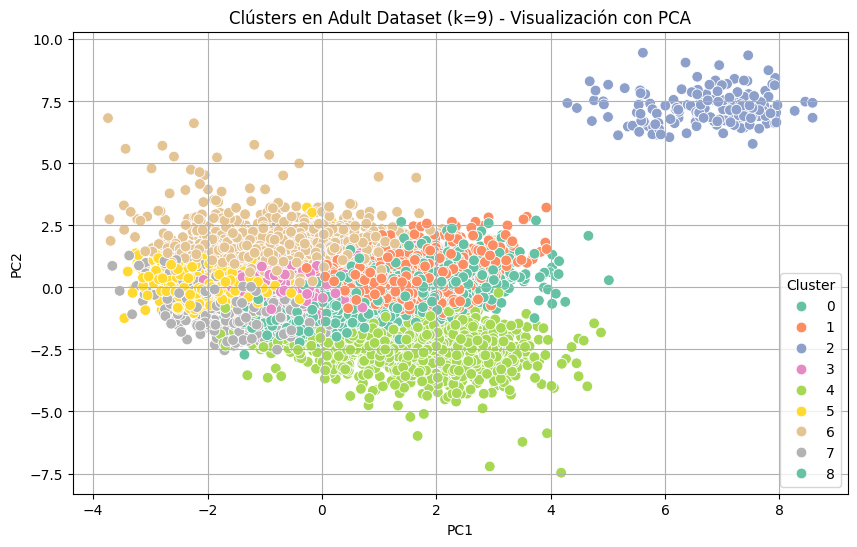

In [12]:
# Aplicar K-means al Dataset adult con el número óptimo de clústers k = 9

kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
df_adult['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df_adult['PC1'] = components[:, 0]
df_adult['PC2'] = components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_adult, palette='Set2', s=60)
plt.title('Clústers en Adult Dataset (k=9) - Visualización con PCA')
plt.grid(True)
plt.show()

# 11.Evaluar los resultados del entrenamiento de house_votes

In [13]:
df_adult['label'].unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
df_adult['label'] = df_adult['label'].str.strip()
# Codificar la variable objetivo
df_adult['label_encoded'] = df_adult['label'].map({'<=50K': 0, '>50K': 1})

# Matriz de confusión
conf_matrix = confusion_matrix(df_adult['label_encoded'], df_adult['Cluster'], labels=[0, 1])
print("Confusion Matrix:\n", conf_matrix)

# Índice de Rand Ajustado
ari = adjusted_rand_score(df_adult['label_encoded'], df_adult['Cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(df_adult['label_encoded'], df_adult['Cluster']))

Confusion Matrix:
 [[3881 3205]
 [1369 2769]]
Adjusted Rand Index (ARI): 0.0321

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.16      0.26     24698
           1       0.46      0.35      0.40      7839
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0.20     32537
   macro avg       0.13      0.06      0.07     32537
weighted avg       0.67      0.20      0.29     32537



/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vscode/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Conclusiones

1. Considero más eficiente el método Silhouette score para evaluar la calidad del clustering, dado que el método del codo se presta más a interpretaciones.
2. El agrupamiento del Dataset house_votes no se realizó correctamente, su acurracy es del 12% unicamente.
3. Es posible para el Dataset house_votes que el número de clústeres (k=2) no represente la complejidad real.
4. El método de calinski harabaz lo encontré más sencillo de implementar y aún más eficiente qué el método de Silhouette score.
5. El agrupamiento del Dataset adult no se realizó correctamente, un accuracy del 20% indica que el modelo no está adecuadamente los datos.
6. Para el Dataset adult, se recomienda mejor un modelo supervisado.
7. Se evidencia en general, que este tipo de data etiquetada, es mejor tratarla con modelos supervisados.



#  REFERENCIAS

Mora, J. (2025). Adquisición y adecuación de base de datos [Notebook]. Google Colab. https://colab.research.google.com/drive/1JafYItjZ-3VuJyHSlKANtHpdHKZ8MGUe?usp=sharing

Bishop, C. (2006). Pattern Recognition and Machine Learning. Information Science and Statistics.

Bonaccorso, G. (2018). Machine Learning Algorithms: Popular Algorithms for Data Science and Machine Learning.Links to an external site. (pp. 307-310).





